# Notebook 06: LoRA Evaluation

- compute accuracy and F1-score

In [1]:
!pwd

/mnt/d/Study/Python Scripts/scimilarity-finetune


# Imports

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
import scanpy as sc
import torch.nn.functional as F
from torch.utils.data import DataLoader
import joblib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from tqdm import tqdm
from scimilarity.nn_models import Encoder, Decoder
import os
import json
from app.utils import load_preprocessed_data, load_artifacts, compute_embeddings, evaluate_knn
from app.model.wrapper import load_encoder, load_decoder, load_lora_encoder
from app.logger_config import get_logger
logger = get_logger()

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

2025-10-20 05:48:20 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.
2025-10-20 05:48:20 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.


# Load processed datasets and artifacts

In [3]:
label_encoder, _, _, _ = load_artifacts()
num_classes = len(label_encoder.classes_)
logger.info(f"number of cell types: {num_classes}")

# String label → integer
label2int = {label: i for i, label in enumerate(label_encoder.classes_)}

# Integer → string label
int2label = {i: label for i, label in enumerate(label_encoder.classes_)}

logger.info(f"Sample int2label:, {list(int2label.items())[:5]}")

2025-10-20 05:48:25 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-20 05:48:25 | 4123527393.py:<module>:3 | INFO | number of cell types: 14
2025-10-20 05:48:25 | 4123527393.py:<module>:11 | INFO | Sample int2label:, [(0, 'GABAergic neuron'), (1, 'T cell'), (2, 'astrocyte'), (3, 'capillary endothelial cell'), (4, 'endothelial cell of artery')]


In [4]:
train_loader, val_loader, test_loader = load_preprocessed_data()


# Inspect a single batch
xb, yb = next(iter(test_loader))

logger.info(f"Features (xb) shape: {xb.shape}")  # [batch_size, num_genes]
logger.info(f"Labels (yb) shape: {yb.shape}")    # [batch_size]
logger.info(f"Features dtype: {xb.dtype}")
logger.info(f"Labels dtype: {yb.dtype}")

# Optional: see first 5 values of first cell
logger.info(f"First cell features (first 5 genes): {xb[0, :5]}")
logger.info(f"First cell label (encoded): {yb[0]}")
logger.info(f"First cell label (decoded): {label_encoder.inverse_transform([yb[0].item()])[0]}")

2025-10-20 05:48:55 | utils.py:load_preprocessed_data:62 | INFO | Train: (14000, 31460), Val: (3000, 31460), Test: (3000, 31460)
2025-10-20 05:48:55 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-20 05:48:56 | 2481640480.py:<module>:7 | INFO | Features (xb) shape: torch.Size([1024, 31460])
2025-10-20 05:48:56 | 2481640480.py:<module>:8 | INFO | Labels (yb) shape: torch.Size([1024])
2025-10-20 05:48:56 | 2481640480.py:<module>:9 | INFO | Features dtype: torch.float32
2025-10-20 05:48:56 | 2481640480.py:<module>:10 | INFO | Labels dtype: torch.int64
2025-10-20 05:48:56 | 2481640480.py:<module>:13 | INFO | First cell features (first 5 genes): tensor([0., 0., 0., 0., 0.])
2025-10-20 05:48:56 | 2481640480.py:<module>:14 | INFO | First cell label (encoded): 8
2025-10-20 05:48:56 | 2481640480.py:<module>:15 | INFO | First cell label (decoded): oligodendrocyte


# Load the baseline encoder + LoRA weights

In [5]:
n_genes = xb.shape[1]
hidden_dim = 1024
logger.info(f"Number of genes (input features): {n_genes}")

# --- 1️⃣ Load best LoRA weights ---
best_epoch = 10
save_dir = "weights/lora/20251020_050117"
lora_path = os.path.join(save_dir, f"lora_epoch{best_epoch}.pt")
lora_weights = torch.load(lora_path)

2025-10-20 05:49:35 | 970482629.py:<module>:3 | INFO | Number of genes (input features): 31460


In [6]:

encoder_lora = load_lora_encoder(n_genes=n_genes, hidden_dim=hidden_dim)

# Inject into encoder_lora
for k, v in lora_weights.items():
    encoder_lora.lora_params[k].data = v.to(device)

encoder_lora.eval()

EncoderWithLoRA(
  (base_encoder): Encoder(
    (network): ModuleList(
      (0): Sequential(
        (0): Dropout(p=0.4, inplace=False)
        (1): Linear(in_features=31460, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (1): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=1024, out_features=1024, bias=True)
        (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): PReLU(num_parameters=1)
      )
      (2): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (lora_params): ParameterDict(
      (0_1_A): Parameter containing: [torch.FloatTensor of size 16x31460]
      (0_1_B): Parameter containing: [torch.FloatTensor of size 1024x16]
      (1_1_A): Parameter containing: [torch.FloatTensor of size 16x1024]
      (1_1_B): Parameter containing: [torch.FloatTens

# Compute embeddings

In [7]:

# --- LoRA Encoder ---
print("Computing LoRA Embeddings...")
train_emb_lora, train_labels = compute_embeddings(encoder_lora, train_loader, device)
val_emb_lora, val_labels     = compute_embeddings(encoder_lora, val_loader, device)
test_emb_lora, test_labels   = compute_embeddings(encoder_lora, test_loader, device)


Computing LoRA Embeddings...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.80it/s]


# KNN Evaluation

2025-10-20 05:49:59 | utils.py:evaluate_knn:190 | INFO | ✅ Saved KNN model to: artifacts/knn_lora.joblib


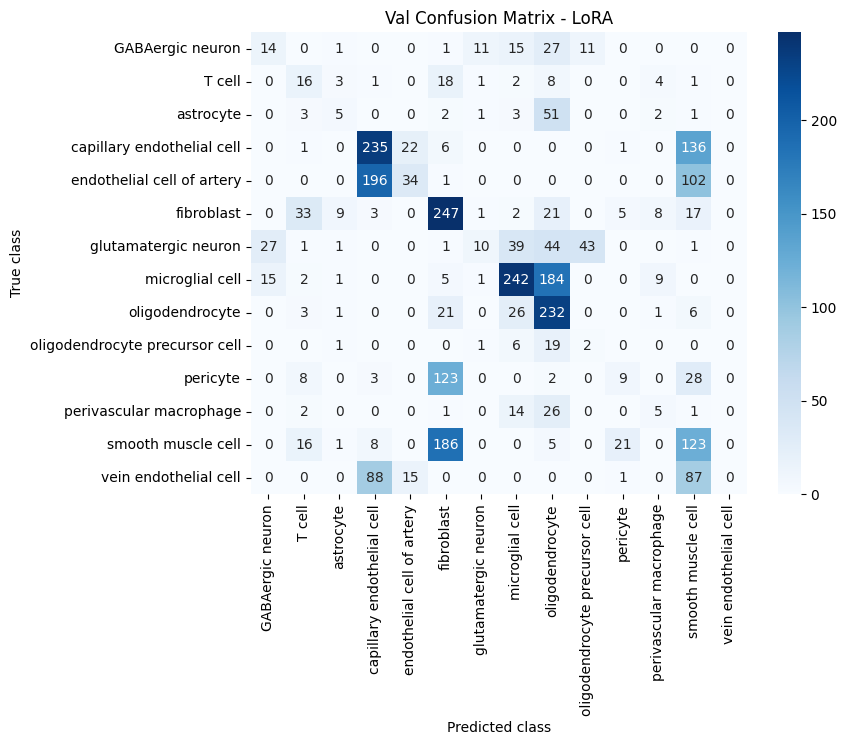

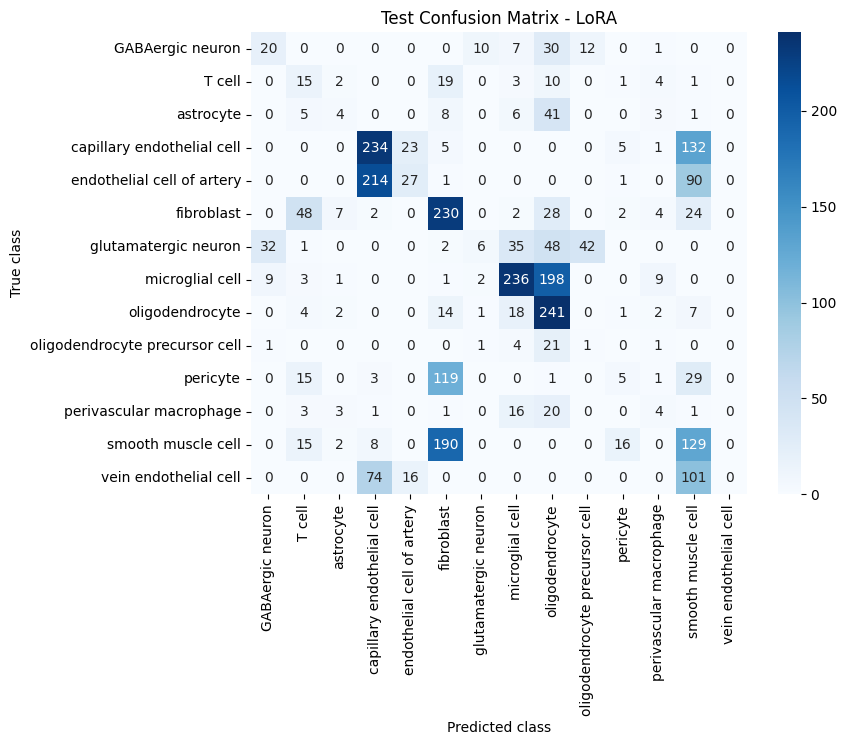

LoRA_Val_acc: 39.13%
LoRA_Val_f1: 24.94%
LoRA_Test_acc: 38.40%
LoRA_Test_f1: 23.82%


In [8]:

# Evaluate LoRA embeddings
results_lora = evaluate_knn(
    train_emb=train_emb_lora, train_labels=train_labels,
    val_emb=val_emb_lora, val_labels=val_labels,
    test_emb=test_emb_lora, test_labels=test_labels,
    label_encoder=label_encoder,
    model_name="LoRA",
    save_model=True
)


# Misclassification Analysis

In [9]:
cm_df = pd.DataFrame(results_lora["LoRA_Val_cm"], index=label_encoder.classes_, columns=label_encoder.classes_)
cm_df

,GABAergic neuron,T cell,astrocyte,capillary endothelial cell,endothelial cell of artery,fibroblast,glutamatergic neuron,microglial cell,oligodendrocyte,oligodendrocyte precursor cell,pericyte,perivascular macrophage,smooth muscle cell,vein endothelial cell
GABAergic neuron,14,0,1,0,0,1,11,15,27,11,0,0,0,0
T cell,0,16,3,1,0,18,1,2,8,0,0,4,1,0
astrocyte,0,3,5,0,0,2,1,3,51,0,0,2,1,0
capillary endothelial cell,0,1,0,235,22,6,0,0,0,0,1,0,136,0
endothelial cell of artery,0,0,0,196,34,1,0,0,0,0,0,0,102,0
fibroblast,0,33,9,3,0,247,1,2,21,0,5,8,17,0
glutamatergic neuron,27,1,1,0,0,1,10,39,44,43,0,0,1,0
microglial cell,15,2,1,0,0,5,1,242,184,0,0,9,0,0
oligodendrocyte,0,3,1,0,0,21,0,26,232,0,0,1,6,0
oligodendrocyte precursor cell,0,0,1,0,0,0,1,6,19,2,0,0,0,0


In [10]:
# --- Compute misclassified counts per true label ---
misclassified_counts = cm_df.sum(axis=1) - np.diag(cm_df.values)
misclassified_counts = misclassified_counts.sort_values(ascending=False)
top5_misclassified = misclassified_counts.head(5)
top5_misclassified

endothelial cell of artery    299
smooth muscle cell            237
microglial cell               217
vein endothelial cell         191
capillary endothelial cell    166
dtype: int64

In [13]:

print("Top 5 misclassified cell populations:")
for true_label in top5_misclassified.index:
    row = cm_df.loc[true_label].drop(true_label)
    most_confused_label = row.idxmax()
    confused_count = row.max()
    total = cm_df.loc[true_label].sum()
    percent = confused_count / total * 100
    print(f"- True Label: {true_label}, Most confused with: {most_confused_label} "
          f"({confused_count}/{total} samples, {percent:.2f}%)")



Top 5 misclassified cell populations:
- True Label: endothelial cell of artery, Most confused with: capillary endothelial cell (196/333 samples, 58.86%)
- True Label: smooth muscle cell, Most confused with: fibroblast (186/360 samples, 51.67%)
- True Label: microglial cell, Most confused with: oligodendrocyte (184/459 samples, 40.09%)
- True Label: vein endothelial cell, Most confused with: capillary endothelial cell (88/191 samples, 46.07%)
- True Label: capillary endothelial cell, Most confused with: smooth muscle cell (136/401 samples, 33.92%)


# Possible Reasons for Misclassification

- Several groups in the UMAP plot appear close together or partially overlapping.
- The feature embeddings extracted by the encoder model may not capture enough information to clearly distinguish between some cell types.
- If two categories have high feature similarity, their embeddings will be close, leading to confusion.
- As the dataset is imbalanced, the model was exposed to a significantly higher number of samples from majority classes compared to minority ones. This imbalance caused the model to learn the dominant class patterns more effectively, while failing to adequately capture the distinguishing characteristics of the underrepresented classes. As a result, the model tends to generalize poorly for minority classes, leading to frequent misclassifications where minority samples are predicted as majority-class examples.

